# Rollout Algorithms

## What are they?
Rollout algorithms are decision-time planning algorithms based on Monte Carlo (MC) control applied to simulated trajectories that all begin at the current environment state. 
They estimate action values for a given policy by averaging the returns of many simulated trajectories that start with each possible action and then follow the given policy.

## Why "rollout"?
As explained by Tesauro and Galperin (1997), who experimented with rollout algorithms for playing backgammon, the term “rollout”
comes from estimating the value of a backgammon position by playing out, i.e., “rolling out,” the position many times to the game’s end with randomly generated sequences of
dice rolls, where the moves of both players are made by some **fixed policy**.
![backgammon](./images/backgammon.jpg)

## Difference from Monte Carlo control algorithms
Unlike the MC control algorithms, the goal of a rollout algorithm is **not** to estimate a complete optimal action-value function, $q^*$, or a
complete action-value function, $q_\pi$, for a given policy $\pi$. Instead, they produce MC estimates of action values only for the **current state** and for a **given policy** usually
called the *rollout policy*. As decision-time planning algorithms, rollout algorithms make immediate use of these action-value estimates, then discard them. This makes rollout
algorithms relatively simple to implement because there is no need to sample outcomes for every state-action pair, and there is no need to approximate a function over either
the state space or the state-action space.

## What then do rollout algorithms accomplish? 
The policy improvement theorem (Sutton and Barto Section 4.2) tells us that given any two policies $\pi$ and $\pi'$ that are identical
except that $\pi' \left( s \right) = a \neq \pi \left( s \right)$ for some state $s$, if $q_\pi \left( s, a \right) \geq v_\pi \left( s \right)$, then policy $\pi'$ is as good as, or better, than $\pi$.  This applies to rollout algorithms where $s$ is the current state and $\pi$ is the *rollout policy*. Averaging the returns of the simulated trajectories produces estimates of $q_\pi \left( s, a' \right)$ for each action $a' \in \mathcal{A} \left( s \right)$. Then the policy that selects an action in $s$ that maximizes these estimates and thereafter follows $\pi$ is a good candidate for a policy that improves over $\pi$. The result is like one step of the policy-iteration algorithm of dynamic programming.

In other words, the aim of a rollout algorithm is to improve upon the *rollout policy*; **not to find an optimal policy**. 

## Tradeoffs
In some applications, a rollout algorithm can produce good performance even if the rollout policy is **completely random**. But the performance of the improved policy depends
on properties of the *rollout policy* and the ranking of actions produced by the MC value estimates. Intuition suggests that the better the *rollout policy* and the more
accurate the value estimates, the better the policy produced by a rollout algorithm is likely to be.

However, better rollout policies typically mean that more time is needed to simulate enough trajectories to obtain good value estimates.
As decision-time planning methods, rollout algorithms usually have to meet strict time constraints. The computation time needed by a rollout algorithm depends on the number
of actions that have to be evaluated for each decision, the number of time steps in the simulated trajectories needed to obtain useful sample returns, the time it takes the rollout
policy to make decisions, and the number of simulated trajectories needed to obtain good Monte Carlo action-value estimates.

# Monte Carlo Tree Search

Monte Carlo Tree Search (MCTS) is a rollout algorithm, enhanced by the addition of a means for accumulating value estimates obtained from the Monte
Carlo simulations in order to successively direct simulations toward more highly-rewarding trajectories. MCTS has proved to be effective in a wide
variety of competitive settings, including general game playing, but it is not limited to games; it can
be effective for single-agent sequential decision problems if there is an environment model simple enough for fast multistep simulation.

MCTS is executed after encountering each new state to select the agent’s action for that state; it is executed again to select the action for the next state, and so on. As in a
rollout algorithm, each execution is an iterative process that simulates many trajectories starting from the current state and running to a terminal state (or until discounting
makes any further reward negligible as a contribution to the return). The core idea of MCTS is to successively focus multiple simulations starting at the current state by
extending the initial portions of trajectories that have received high evaluations from earlier simulations. 

For the most part, the actions in the simulated trajectories are generated using a simple policy, usually called a *rollout policy* as it is for simpler rollout algorithms. When both
the rollout policy and the model do not require a lot of computation, many simulated trajectories can be generated in a short period of time. The value of a state–action pair is estimated as the average of the (simulated) returns from that pair. Monte Carlo value estimates are maintained only for the subset
of state–action pairs that are most likely to be reached in a few steps, which form a tree rooted at the current state.
MCTS incrementally extends the tree by adding nodes representing states that look promising based on the results
of the simulated trajectories. Any simulated trajectory will pass through the tree and
then exit it at some leaf node. Outside the tree and at the leaf nodes the *rollout policy* is
used for action selections, but at the states inside the tree something better is possible.
For these states we have value estimates for at least some of the actions, so we can pick
among them using an informed policy, called the *tree policy*, that balances exploration
and exploitation. Tree policy examples include: 
1. $\epsilon$-greedy.
2. UCB  

![UCB](./images/ucb.jpg)

## MCTS iteration overview
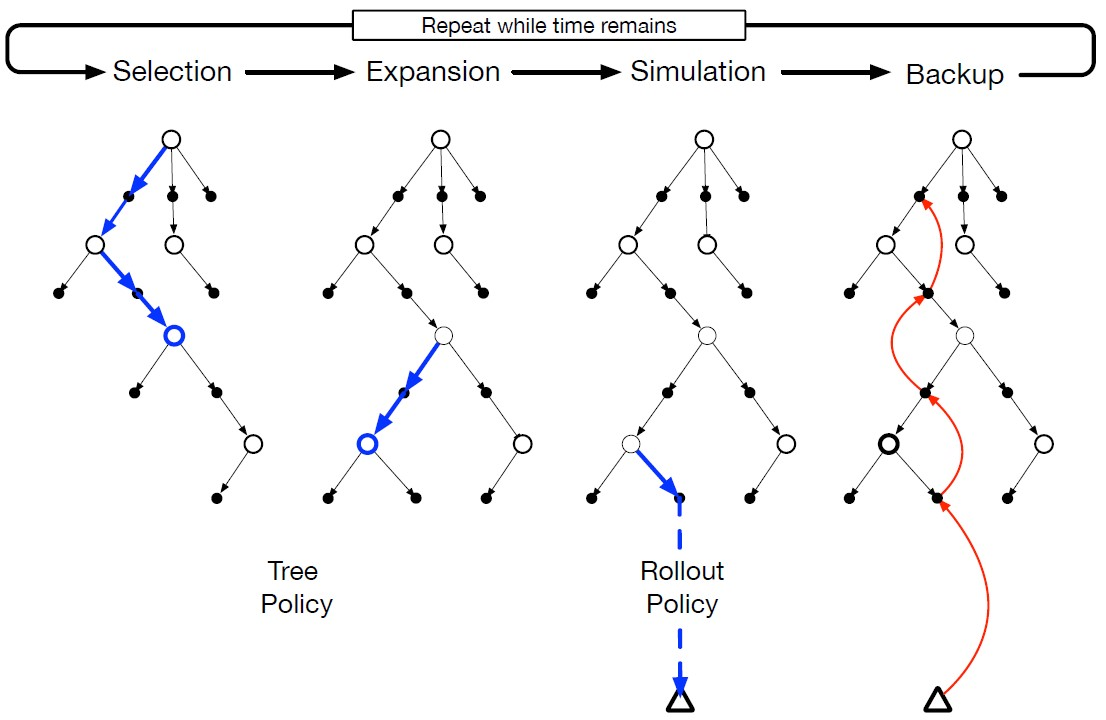](./images/mcts.jpg)

Each iteration of a basic version of MCTS consists of the following four:

1. **Selection**. Starting at the root node, a *tree policy* based on the action values attached to the edges of the tree traverses the tree to select a leaf node.

2. **Expansion**. On some iterations (depending on details of the application), the tree is expanded from the selected leaf node by adding one or more child nodes reached
from the selected node via unexplored actions.

3. **Simulation**. From the selected node, or from one of its newly-added child nodes (if any), simulation of a complete episode is run with actions selected by the *rollout
policy*. The result is a Monte Carlo trial with actions selected first by the *tree policy* and beyond the tree by the *rollout policy*.

4. **Backup**. The return generated by the simulated episode is backed up to update, or to initialize, the action values attached to the edges of the tree traversed by
the *tree policy* in this iteration of MCTS. No values are saved for the states and actions visited by the *rollout policy* beyond the tree. 

MCTS continues executing these four steps, starting each time at the tree’s root node, until no more time is left, or some other computational resource is exhausted. Then,
finally, an action from the root node (which still represents the current state of the environment) is selected according to some mechanism that depends on the accumulated
statistics in the tree; for example, it may be an action having the largest action value of all the actions available from the root state, or perhaps the action with the largest
visit count to avoid selecting outliers. This is the action MCTS actually selects. After the environment transitions to a new state, MCTS is run again, sometimes starting with a tree of a single root node representing the new state, but often starting with a tree containing any descendants of this node left over from the tree constructed by the previous execution of MCTS; all the remaining nodes are discarded, along with the action values associated with them.

## RL?
At its base, MCTS is a decision-time planning algorithm based on Monte Carlo control applied to simulations
that start from the root state; that is, it is a kind of rollout algorithm as described in the previous section. It therefore benefits from online, incremental, sample-based value
estimation and policy improvement. Beyond this, it saves action-value estimates attached to the tree edges and updates them using reinforcement learning’s sample updates. This
has the effect of focusing the Monte Carlo trials on trajectories whose initial segments are common to high-return trajectories previously simulated. Further, by incrementally
expanding the tree, MCTS effectively grows a lookup table to store a partial action-value function, with memory allocated to the estimated values of state–action pairs visited in
the initial segments of high-yielding sample trajectories. MCTS thus avoids the problem of globally approximating an action-value function while it retains the benefit of using
past experience to guide exploration.

# Implementation

## MultiTaxi Environment
We begin with some imports:

In [1]:
import numpy as np
from collections import defaultdict
from multi_taxi.taxi_environment import simple_MAP, orig_MAP
from multi_taxi import MultiTaxiEnv
from gym import Wrapper
from IPython.display import clear_output
import matplotlib.pyplot as plt

A singleTaxi Wrapper allows us to reset the environment with predefined taxi and passenger locations:

In [2]:
class SingleTaxiWrapper(Wrapper):
    """
    A wrapper for multi-taxi environments aligning the environments'
    API with OpenAI Gym if using only 1 taxi.
    """
    def __init__(self, env, taxi_pos, passenger_pose):
        assert env.num_taxis == 1
        super().__init__(env)
        self.__taxi_pos = taxi_pos
        self.__passenger_pose = passenger_pose
        
    def reset(self):
        # run `reset` as usual.
        # returned value is a dictionary of observations with a single entry
        obs = self.env.reset()
        
        a, b, _, c, d = self.unwrapped.state
        self.unwrapped.state = [[self.__taxi_pos], b, [self.__passenger_pose], c, d]
        
        # return the single entry value as is.
        # no need for the key (only one agent)
        ret = next(iter(obs.values()))
        
        return ret

    def step(self, action):
        # step using "joint action" of a single agnet as a dictionary
        step_rets = self.env.step({self.env.taxis_names[0]: action})

        # unpack step return values from their dictionaries
        return tuple(next(iter(ret.values())) for ret in step_rets)

We define some hyperparameters

In [3]:
customized_reward = dict(pickup=100,bad_pickup=-1,hit_wall=-1)
N_SIMULATIONS = 50

A helper function do setup a new environment with predefined taxi and passenger locations

In [4]:
def new_environment_creator(taxi_pos, passenger_pos, 
                            num_taxis=1,num_passengers=1, 
                            pickup_only=True, can_see_others=False, 
                            domain_map=orig_MAP,rewards_table=customized_reward):
    """
    A helper function to setup a new environment with predefined taxi and passenger locations
    """
    new_env = MultiTaxiEnv(num_taxis=num_taxis, num_passengers=num_passengers, pickup_only=pickup_only, 
                           can_see_others=can_see_others, domain_map=domain_map,rewards_table=rewards_table)
    new_env = SingleTaxiWrapper(new_env, taxi_pos=taxi_pos[0], passenger_pose=passenger_pos[0])
    new_env.reset()
    return new_env

We define the MCTS tree node

In [5]:
class MonteCarloTreeSearchNode():
    def __init__(self, state, parent=None, parent_action=None, new_env_creator=new_environment_creator):
        self.state = state  #represents the state
        self.parent = parent #None for the root node, otherwise it is equal to the node it is derived from.
        self.parent_action = parent_action #None for the root node, otherwise it is equal to the action which it’s parent carried out.
        self.children = [] #Contains all possible actions from the current node.
        self._number_of_visits = 0 #Number of times current node is visited.
        self._results = defaultdict(int)
        self._results[1] = 0
        self._results[-1] = 0
        self._untried_actions = self.get_legal_actions() #Represents the list of all possible actions. An action is a move which has to be carried out.
        self.terminal_state = False
        self.new_env_creator = new_env_creator
        
    def q(self):
        """
        Returns the accumulated reward
        """
        reward = self._results[1]
        return reward
        
    def n(self):
        """
        Returns the number of times each node is visited.
        """
        return self._number_of_visits
    
    def expand(self):
        """
        From the present state, next state is generated depending on the action 
        which is carried out. In this step all the possible child nodes 
        corresponding to generated states are appended to the children array 
        and the child_node is returned. The states which are possible from the
        present state are all generated and the child_node corresponding to this
        generated state is returned.
        """
        action = self._untried_actions.pop()
        
        taxi_pos,_,passenger_pos,_,_ = self.state.env.state
        new_env = self.new_env_creator(taxi_pos,passenger_pos)
        obs, reward, done, info = new_env.step(action)
        child_node = MonteCarloTreeSearchNode(new_env, parent=self, parent_action=action)
        child_node.terminal_state = done
        
        self.children.append(child_node)
        return child_node
    
    def is_terminal_node(self):
        """
        This is used to check if the current node is terminal or not. 
        Terminal node is reached when the game is over.
        """
        return self.terminal_state
    
    def rollout(self):
        """
        From the current state, entire game is simulated till there is an 
        outcome for the game. This outcome of the game is returned.
        """
        taxi_pos,_,passenger_pos,_,_ = self.state.env.state
        
        current_rollout_state = self.new_env_creator(taxi_pos,passenger_pos)

        _reward = 0
        done = False
        while not done:
            possible_moves = self.get_legal_actions()

            action = self.rollout_policy(possible_moves)
            obs, reward, done, info = current_rollout_state.step(action)
            _reward += reward
        return _reward
    
    def backpropagate(self, reward):
        """
        In this step all the statistics for the nodes are updated. 
        Untill the parent node is reached, the number of visits for 
        each node is incremented by 1.
        """
        self._number_of_visits += 1.
        self._results[1] += reward
        if self.parent:
            self.parent.backpropagate(reward)
            
    def is_fully_expanded(self):
        """
        All the actions are poped out of _untried_actions one by one. 
        When it becomes empty, that is when the size is zero, it is fully expanded.
        """
        return len(self._untried_actions) == 0
    
    def best_child(self, c_param=0.8):
        """
        Once fully expanded, this function selects the best child out of 
        the children array. The first term in the formula corresponds to 
        exploitation and the second term corresponds to exploration.
        """
        choices_weights = [(c.q() / c.n()) + c_param * np.sqrt((2 * np.log(self.n()) / c.n())) for c in self.children]
        return self.children[np.argmax(choices_weights)]
    
    def rollout_policy(self, possible_moves):
        """
        Randomly selects a move out of possible moves. 
        This is an example of random playout.
        """
        return possible_moves[np.random.randint(len(possible_moves))]
    
    def _tree_policy(self):
        """
        Selects node to run rollout.
        """
        current_node = self
        while not current_node.is_terminal_node():

            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node
    
    def best_action(self):
        """
        This is the best action function which returns the 
        node corresponding to best possible move. The step of expansion, 
        simulation and backpropagation are carried out by the code above.
        """
        
        for i in range(N_SIMULATIONS):
            #if i % 1000 == 0:
            #    print(i,"/",simulation_no)
            v = self._tree_policy()
            reward = v.rollout()
            v.backpropagate(reward)

        return self.best_child(c_param=0.)
    
    def get_legal_actions(self): 
        '''
        Modify according to your game or
        needs. Constructs a list of all
        possible actions from current state.
        Returns a list.
        '''
        return list(range(self.state.action_space.n))    

We can now initialize the root node and run

In [6]:
N_SIMULATIONS = 100
env = new_environment_creator(taxi_pos=[[0,0]],passenger_pos=[[3,3]])
root = MonteCarloTreeSearchNode(state = env)
root.state.render()
selected_node = root.best_action()
step = 1
while not selected_node.terminal_state:
    selected_node = selected_node.best_action()
    clear_output(wait=True)
    print(step)
    selected_node.state.render()
    step += 1

13
+---------+
| : | : : |
| : | : : |
| : : : : |
| | : | : |
| | : | : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (3,3), Collided: False
Passenger1: Location: Taxi1, Destination: pickup only!
Done: True, {'taxi_0': True, '__all__': True}
Passengers Status's: [3]


We compare the number of steps it takes to find a solution as a function of the number of MCTS simulations

29
+---------+
| : | : : |
| : | : : |
| : : : : |
| | : | : |
| | : | : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (3,3), Collided: False
Passenger1: Location: Taxi1, Destination: pickup only!
Done: True, {'taxi_0': True, '__all__': True}
Passengers Status's: [3]
[37, 49, 37, 15, 28, 30]


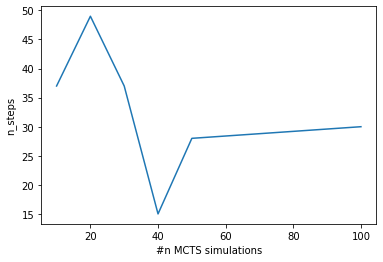

In [7]:
results = []
simulations = [10,20,30,40,50,100]
for steps in simulations:
    N_SIMULATIONS = steps
    env = new_environment_creator(taxi_pos=[[0,0]],passenger_pos=[[3,3]])
    root = MonteCarloTreeSearchNode(state = env)
    root.state.render()
    selected_node = root.best_action()
    step = 1
    while not selected_node.terminal_state:
        selected_node = selected_node.best_action()
        clear_output(wait=True)
        print(step)
        selected_node.state.render()
        step += 1
    results.append(step)
print(results)
plt.plot(simulations,results)
plt.plot()
plt.xlabel('#n MCTS simulations')
plt.ylabel('n_steps')
plt.show()

# Simple V2 Environment
As MCTS requires we hold the environment/state in each tree node, we can not use the Simple V2 evnironment as it does not allow setting the environment manually